This is the script to fit L-B model to experimental data in order to extract Delta T. It will require you to load: experimental data (text file), SSE for A vs µ (JSON file), and calculated transmission probability (JSON file).

# Imports

In [7]:
import numpy as np
import matplotlib.pyplot  as plt
import warnings
from tqdm import tqdm
import json
import tkinter as tk
from tkinter import filedialog as fd
from ratchet_functions import *
from cProfile import label
from matplotlib.pyplot import legend
from matplotlib import cm

# Constants

In [8]:
k_B=8.617E-5 #eV
m_e = 9.11E-31 #kg
m_eff=0.023; #Effective mass InAs, in free electron mass.
h_bar = 1.05E-34 #Js
h2m = h_bar**2/(2*m_e*m_eff)*6.24E18 # [eVm^2], 6.24E18 converts from J to eV

# Settings

In [28]:
T_K=77; # Base temperature in K
kT=T_K*k_B; # K to meV

load_raw_data = 1
save_figs = 0
save_data = 0

#Figures, Nature standard
figwidth = 3.45 
figheight = 3.45
%matplotlib inline
plt.rcParams.update({'font.size': 7})      
plt.rcParams["font.family"] = "Arial" 
plt.rcParams.update({'mathtext.default': 'regular'})

color_D = (0/255, 137/255, 207/255)
color_D_shade = (44/255, 161/255, 218/255)
color_S = (237/255, 20/255, 80/255)
color_S_shade = (241/255, 112/255, 119/255)

# Loading data


## Experimental data
These measurements were taken during the same measurement series with the same BG voltage, directly after eachother, heating voltage is stepped on either side, and one reference measurement without any heating is done afterwards to assure the IV curve under no heating still looks the same

In [10]:
load_raw_data = 1   #If you don't wanna ahve to open the file explorere everytime you run the script put this to = 0 and paste filepath below
if load_raw_data == 1:
    filename_heat_gradient_side = get_file(title = 'txt file for IV with heating on gradient side ')
    filename_heat_steep_side = get_file(title = 'txt file for IV with heating on steep side ')

elif load_raw_data == 0:
    filename_heat_gradient_side = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Jonatans projects/Ratchet barrier/Data/Raw data used in paper/B1_N2_0911_log15.txt'
    filename_heat_steep_side = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Jonatans projects/Ratchet barrier/Data/Raw data used in paper/B1_N2_0911_log14.txt' 


In [11]:
V_h = np.linspace(0, 0.4, 9) #array of the applied total V_h, read manually from text data file, typically it is applied symetrically +/- across the heater so you need to add them up
n_sweeps = 6 #number of IV sweeps per heating voltage


### Heating on gradient side ###
filename_G = filename_heat_gradient_side   
Data_G = np.loadtxt(filename_G, skiprows=2)    
V_bias_G = Data_G[:,1]
I_raw_G = Data_G[:,2:]
### for each heating voltage, average IV curve over n_sweeps number of sweeps and create matrix with averaged IV curves for each Vh
I_exp_G, I_std_G = Average_IV_sweeps(counter = len(V_h), n_sweeps = n_sweeps, I_raw = I_raw_G)
I_exp_dark_G = I_exp_G[:,0]

### Heating on steep side ###
filename_S = filename_heat_steep_side   
Data_S = np.loadtxt(filename_S, skiprows=2)    
V_bias_S = Data_S[:,1]
I_raw_S = Data_S[:,2:]
### for each heating voltage, average IV curve over n_sweeps number of sweeps and create matrix with averaged IV curves for each Vh
I_exp_S, I_std_D = Average_IV_sweeps(counter = len(V_h), n_sweeps = n_sweeps, I_raw = I_raw_S)
I_exp_dark_S = I_exp_S[:,0]

V_sd = V_bias_G


Plot

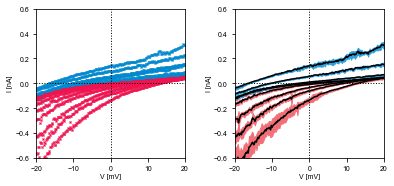

In [31]:

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_position([0.15, 0.2, 0.3, 0.6])
ax2.set_position([0.55, 0.2, 0.3, 0.6])
ax1.plot(V_bias_S*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2, label='steep')
ax1.plot(V_bias_G*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2, label='gradient')
vline = ax1.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax1.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax1.set_xlim(-20, 20)
ax1.set_ylim(-0.6, 0.6)
ax1.set_xlabel('V [mV]', labelpad=2)
ax1.set_ylabel('I [nA]', labelpad=2)

#Fig 2 plots a couple of the IV curves together with theri corresponding standard deviation (std)
#ax2.plot(V_bias_S*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2, label='steep')
#ax2.plot(V_bias_G*1E3, I_exp_G[:,0]*1E9, color = (237/255, 20/255, 80/255), ms = 2)
ax2.plot(V_bias_G*1E3, I_exp_G[:,0]*1E9, 'k')
plt.fill_between(V_bias_G*1E3, (I_exp_G[:,0]+I_std_G[:,0])*1E9, (I_exp_G[:,0]-I_std_G[:,0])*1E9, color = (241/255, 112/255, 119/255)) 

ax2.plot(V_bias_G*1E3, I_exp_G[:,3]*1E9, 'k')
plt.fill_between(V_bias_G*1E3, (I_exp_G[:,3]+I_std_G[:,3])*1E9, (I_exp_G[:,3]-I_std_G[:,3])*1E9, color = color_S_shade) 
ax2.plot(V_bias_S*1E3, I_exp_S[:,3]*1E9, 'k')
plt.fill_between(V_bias_S*1E3, (I_exp_S[:,3]+I_std_D[:,3])*1E9, (I_exp_S[:,3]-I_std_D[:,3])*1E9, color = (44/255, 161/255, 218/255)) 

ax2.plot(V_bias_G*1E3, I_exp_G[:,-4]*1E9, 'k')
plt.fill_between(V_bias_G*1E3, (I_exp_G[:,-4]+I_std_G[:,-4])*1E9, (I_exp_G[:,-4]-I_std_G[:,-4])*1E9, color = color_S_shade) 

ax2.plot(V_bias_G*1E3, I_exp_G[:,-3]*1E9, 'k')
plt.fill_between(V_bias_G*1E3, (I_exp_G[:,-3]+I_std_G[:,-3])*1E9, (I_exp_G[:,-3]-I_std_G[:,-3])*1E9, color = color_S_shade) 
ax2.plot(V_bias_S*1E3, I_exp_S[:,-3]*1E9, 'k')
plt.fill_between(V_bias_S*1E3, (I_exp_S[:,-3]+I_std_D[:,-3])*1E9, (I_exp_S[:,-3]-I_std_D[:,-3])*1E9, color = (44/255, 161/255, 218/255)) 

ax2.plot(V_bias_G*1E3, I_exp_G[:,-1]*1E9, 'k')
plt.fill_between(V_bias_G*1E3, (I_exp_G[:,-1]+I_std_G[:,-1])*1E9, (I_exp_G[:,-1]-I_std_G[:,-1])*1E9, color = color_S_shade) 
ax2.plot(V_bias_S*1E3, I_exp_S[:,-1]*1E9, 'k')
plt.fill_between(V_bias_S*1E3, (I_exp_S[:,-1]+I_std_D[:,-1])*1E9, (I_exp_S[:,-1]-I_std_D[:,-1])*1E9, color = (44/255, 161/255, 218/255)) 

#ax2.plot(V_bias_G*1E3, (I_exp_G[:,0]+I_std_G[:,0])*1E9, 'k')
ax2.axvline(x=0, linestyle=':', color='k', linewidth = 1)
ax2.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax2.set_xlabel('V [mV]', labelpad=2)
ax2.set_ylabel('I [nA]', labelpad=2)
ax2.set_xlim(-20, 20)
ax2.set_ylim(-0.6, 0.6)

fig.set_size_inches(figwidth*2, figheight)


save_figs=1
if save_figs == 1:
    savename_fig = get_savefile(title='Save IV curves as (no extension)')
    fig.savefig(savename_fig+'.svg')
    fig.savefig(savename_fig+'.png')

## Load results from fits of A and µ
i.e. the SSE error map done in script "Ratchet_analysis_dark.ipynb". The JSON files is found in "Ratchet barrier/Model/Fit A and mu to dark curve", and I use the one labelled "Error_A_and_mu_L92nm_Utop_340meV"

In [13]:
load_dark = 1

if load_dark == 1:
    filename_dark = get_file(title = 'json file containing results from fit to "dark" curve')
elif load_dark == 0:
    filename_dark = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Projects/Ratchet barrier/For storage/Model/Adaption/Error_A_and_mu_L92nm_Utop_340meV.json'
Jason_dark = open(filename_dark, 'r').read()
dictionary_dark = json.loads(Jason_dark)

#parameters to load
Error_A_mu = np.array(dictionary_dark['Error'])
A_array= np.array(dictionary_dark['Ampl_list'])
mu_array = np.array(dictionary_dark['mu_list'])




In [14]:
Error_min_index = []

for i in range(len(mu_array)):
    Error_min_index.append([i,  np.argmin(Error_A_mu[i,:])])


Error_min_array = np.zeros(len(mu_array)) #The smallest error for each µ
A_min_array = np.zeros(len(mu_array))   #The A that minimizes error for each µ
for i in range(len(mu_array)):
    A_min_array[i] = A_array[Error_min_index[i][1]]
    Error_min_array[i] = Error_A_mu[Error_min_index[i][0], Error_min_index[i][1]]

Error_min = min(Error_min_array)
mu_min = mu_array[find_nearest(Error_min_array, Error_min)]
A_min = A_min_array[find_nearest(Error_min_array, Error_min)]


Plot

Text(0, 0.5, 'A [a.u.]')

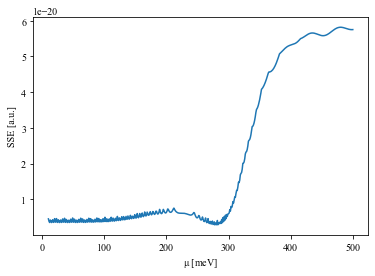

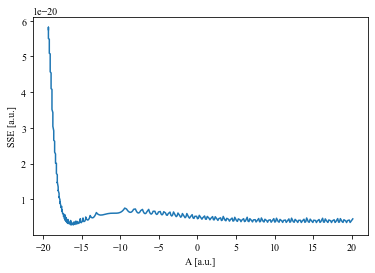

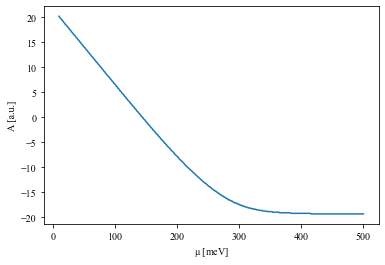

In [15]:
fig1, ax1 = plt.subplots()
#ax.set_position([0.2, 0.15, 0.7, 0.7])    # Manually set "data frame" size: x, y, widht, height in precentage of full window
#fig.set_size_inches(figwidth, figheight)

ax1.plot(mu_array*1E3, Error_min_array)

#ax.secondary_xaxis('top', np.log(functions=(deg2rad, rad2deg))
ax1.set_xlabel('$\mu $ [meV]')
ax1.set_ylabel('SSE [a.u.]')

fig2,ax2 = plt.subplots()
ax2.plot(np.log(A_min_array), Error_min_array)
ax2.set_xlabel('A [a.u.]')
ax2.set_ylabel('SSE [a.u.]')

fig3,ax3 = plt.subplots()
ax3.plot(mu_array*1E3, np.log(A_min_array))
ax3.set_xlabel('$\mu $ [meV]')
ax3.set_ylabel('A [a.u.]')

User makes the choice of µ from diagrams, the corresponding A that gives the minimum is then extracted from A_min_array. SEE ALSO the figures/description on adaptation in SI if this part is confusing

In [16]:
mu = 0.1    #[eV] 
A = A_min_array[find_nearest(mu_array,mu)]

# Load transmission
Transmission probability is calculated in a separate script "Calculate_transmission.ipynb", the output files are located in folder Ratchet barrier/Model/Calculated transmission in JSON format.
I recommend choosing the file with the highest number of steps for the voltage range applicable, e.g. "20mV" in file name means Vsd is varied in the range +/- 20 mV, so the file "Transmission_20mv_340meV_92nm_1000steps" would then be suitable, wheer 340meV_92nm define the barrier geometry (height and length)

In [ ]:
load_T = 0

if load_T == 1:
    filename_T = get_file(title = 'json file containing calculated transmission')
elif load_T== 0:
    filename_T = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Jonatans projects/Ratchet barrier/Model/Calculated transmission/Transmission_20mv_340meV_92nm_1000steps.json'
    
Jason_T = open(filename_T, 'r').read()
dictionary_T = json.loads(Jason_T)

E_array = np.array(dictionary_T['E'])
T_QM = np.array(dictionary_T['T_QM']).T
T_WKB = np.array(dictionary_T['T_WKB']).T

L=dictionary_T['L'] #barrier length in m 
U_top=dictionary_T['U_top'] #barrier height in eV
dE=dictionary_T['dE'] #Integration stepsize for landauer Buttiker integral


Plot transmission

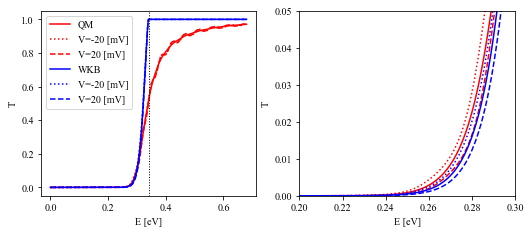

In [ ]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(E_array, T_QM[:,int(len(V_sd)/2)], 'r', label = 'QM')
ax1.plot(E_array, T_QM[:,-1], 'r:', label = 'V=-20 [mV]')
ax1.plot(E_array, T_QM[:,0], 'r--', label = 'V=20 [mV]')
ax1.plot(E_array, T_WKB[:,int(len(V_sd)/2)], 'b', label = 'WKB')
ax1.plot(E_array, T_WKB[:,-1], 'b:', label = 'V=-20 [mV]')
ax1.plot(E_array, T_WKB[:,0], 'b--', label = 'V=20 [mV]')
ax1.axvline(x=U_top, linestyle=':', color='k', linewidth = 1)
ax1.legend()
ax1.set_xlabel('E [eV]')
ax1.set_ylabel('T')
ax2.set_ylim(0, 1)# 0.01)
ax2.set_xlim(0, 1) #0.48, 0.52)

ax2.plot(E_array, T_QM[:,int(len(V_sd)/2)], 'r', label = 'QM')
ax2.plot(E_array, T_QM[:,-1], 'r:', label = 'V=-20 [mV]')
ax2.plot(E_array, T_QM[:,0], 'r--', label = 'V=20 [mV]')
ax2.plot(E_array, T_WKB[:,int(len(V_sd)/2)], 'b', label = 'WKB')
ax2.plot(E_array, T_WKB[:,-1], 'b:', label = 'V=-20 [mV]')
ax2.plot(E_array, T_WKB[:,0], 'b--', label = 'V=20 [mV]')
ax2.set_ylim(0, 0.05)# 0.01)
ax2.set_xlim(0.2, 0.3) #0.48, 0.52)
ax2.set_xlabel('E [eV]')
ax2.set_ylabel('T')

fig.set_size_inches(figwidth*2.5, figheight)

# Fitting Delta T, QM model

Settings:

In [34]:
kDeltaT_G  = np.linspace(0, 13, 130+1)*k_B       #the range of Delta T to which the experimental data will be fitted, in eV
kDeltaT_S = kDeltaT_G
V_sd = V_bias_G     #because V should be the same as in experiment, both ragne and number of steps

Calculate a guess IV curve, this is not used further but can be a good sanity check

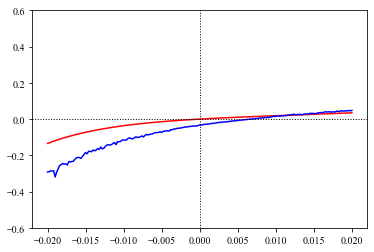

In [27]:
I_guess = np.zeros(len(V_sd))
for k, V in enumerate(V_sd):
    f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = 0,kDeltaT_S = 0, T = 77)
    I_guess[k] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)
Error_min = SumOfSquaredError(I_guess, I_exp_G[:,5])

plt.figure()
plt.plot(V_sd, I_guess*1E9, 'r')
plt.plot(V_sd, I_exp_G[:,5]*1E9, 'b')
plt.ylim(-0.6, 0.6)
plt.axvline(x=0, linestyle=':', color='k', linewidth = 1)
plt.axhline(y=0, linestyle=':', color='k', linewidth = 1)

# Fit Delta T to IV curves with heating on gradient or steep side

In [108]:
fit_power_quadrant_G = 1     #This determines wether the error calculation is done across the whole IV curve range (0), or just withing the region of the power producing quadrant (1)
fit_power_quadrant_S = 1

### Heating on gradient (gradient) side ###

if fit_power_quadrant_G == 1:
        
   

    start_G, stop_G = indices_power_quadrant(I_exp_G[:,-1], V_sd)    #Take the region from the last (highest heating) IV curve only, so that they all are fitted in same region

    Error_min_G = np.zeros(len(V_h))

    Error_G = np.zeros((len(kDeltaT_G),len(V_h)))
    for i, V_heat in enumerate(tqdm(V_h, position=0, leave=True)):
        I_exp = I_exp_G[:,i][start_G:stop_G]

        for j, DT_G in enumerate(kDeltaT_G):     
            I_temp = np.zeros(len(V_sd))
            for k, V in enumerate(V_sd):
                f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = DT_G ,kDeltaT_S = 0, T = 77)
                I_temp[k] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)

            Error_temp = SumOfSquaredError(I_temp[start_G:stop_G], I_exp)
            Error_G[j, i] = Error_temp

elif fit_power_quadrant_G == 0:

    Error_min_G = np.zeros(len(V_h))

    Error_G = np.zeros((len(kDeltaT_G),len(V_h)))
    for i, V_heat in enumerate(tqdm(V_h, position=0, leave=True)):
        I_exp = I_exp_G[:,i]

        for j, DT_G in enumerate(kDeltaT_G):     
            I_temp = np.zeros(len(V_sd))
            for k, V in enumerate(V_sd):
                f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = DT_G ,kDeltaT_S = 0, T = 77)
                I_temp[k] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)

            Error_temp = SumOfSquaredError(I_temp, I_exp)
            Error_G[j, i] = Error_temp


if fit_power_quadrant_S == 1:
### Heating on steep (steep) side ###

    start_S, stop_S = indices_power_quadrant(I_exp_S[:,-1], V_sd)    #Take the region from the last (highest heating) IV curve only, so that they all are fitted in same region

    Error_min_S = np.zeros(len(V_h))

    Error_S = np.zeros((len(kDeltaT_S),len(V_h)))
    for i, V_heat in enumerate(tqdm(V_h, position=0, leave=True)):
        I_exp = I_exp_S[:,i][start_S:stop_S]

        for j, DT_S in enumerate(kDeltaT_S):     
            I_temp = np.zeros(len(V_sd))
            for k, V in enumerate(V_sd):
                f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = 0 ,kDeltaT_S = DT_S, T = 77)
                I_temp[k] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)

            Error_temp = SumOfSquaredError(I_temp[start_S:stop_S], I_exp)
            Error_S[j, i] = Error_temp


elif fit_power_quadrant_S == 0:
    ### Heating on steep (steep) side ###
    #start_S, stop_S = indices_power_quadrant(I_exp_S[:,-1], V_sd)    #Take the region from the last (highest heating) IV curve only, so that they all are fitted in same region

    Error_min_S = np.zeros(len(V_h))

    Error_S = np.zeros((len(kDeltaT_S),len(V_h)))
    for i, V_heat in enumerate(tqdm(V_h, position=0, leave=True)):
        I_exp = I_exp_S[:,i]

        for j, DT_S in enumerate(kDeltaT_S):     
            I_temp = np.zeros(len(V_sd))
            for k, V in enumerate(V_sd):
                f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = 0 ,kDeltaT_S = DT_S, T = 77)
                I_temp[k] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)

            Error_temp = SumOfSquaredError(I_temp, I_exp)
            Error_S[j, i] = Error_temp

100%|██████████| 9/9 [00:41<00:00,  4.59s/it]


Plot errormaps

Text(0, 0.5, 'SSE [a.u.]')

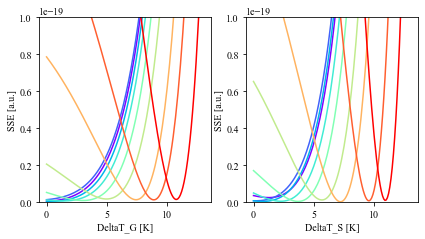

In [109]:

fig_error, (ax_error_1, ax_error_2) = plt.subplots(1,2)
fig_error.set_size_inches(figwidth*2, figheight)
colors = iter(cm.rainbow(np.linspace(0, 1, len(V_h))))
for i in range(len(V_h)):
    color_i = next(colors)
    ax_error_1.plot(kDeltaT_G/k_B, Error_G[:,i], color = color_i)
    ax_error_2.plot(kDeltaT_S/k_B, Error_S[:,i], color = color_i)


ax_error_1.set_ylim(0, 1E-19)
ax_error_1.set_xlabel('DeltaT_G [K]', labelpad=2)
ax_error_1.set_ylabel('SSE [a.u.]', labelpad=2)

ax_error_2.set_ylim(0, 1E-19)
ax_error_2.set_xlabel('DeltaT_S [K]', labelpad=2)
ax_error_2.set_ylabel('SSE [a.u.]', labelpad=2)


Find the minimas of the fitted SSE for each heater setting

In [110]:
### Min temp

force_DT_zero = 1

kT_min_G = np.zeros(len(V_h))
kT_min_S = np.zeros(len(V_h))
for i in range(len(V_h)):
    #gradient (gradient) side
    kT_min_G[i] = kDeltaT_G[np.argmin(Error_G[:,i])]#T_min = 4*k_B#
    #steep (steep) side
    kT_min_S[i] = kDeltaT_S[np.argmin(Error_S[:,i])]#T_min = 4*k_B#


###Calculate IV curve for corresponding temps
I_model_G = np.zeros((len(V_sd), len(V_h)))
I_model_S = np.zeros((len(V_sd), len(V_h)))
for i in range(len(V_h)):   
    for j, V in enumerate(V_sd):
        #gradient (gradient) side
        f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = kT_min_G[i],kDeltaT_S = 0, T = 77)
        I_model_G[j, i] = Landauer_Buttiker(T_QM[:,j], f_S, f_G, A, dE)
       #steep (steep) side

        f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = 0 ,kDeltaT_S = kT_min_S[i], T = 77)
        I_model_S[j, i] = Landauer_Buttiker(T_QM[:,j], f_S, f_G, A, dE)


if force_DT_zero == 1:
    kT_min_G[0] = 0
    kT_min_S[0] = 0

    for k, V in enumerate(V_sd):
        f_G, f_S = fermi_dirac(mu = mu, E = E_array, V = V, kDeltaT_G = 0,kDeltaT_S = 0, T = 77)
        I_model_G[k,0]= Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)
        I_model_S[k,0] = I_model_G[k,0]

Plot

Text(0.5, 0, '$\\Delta V_H$ [V]')

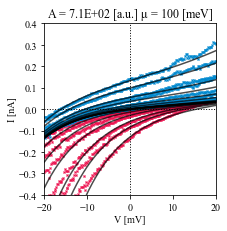

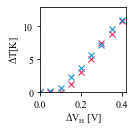

In [111]:
%matplotlib inline

fig_IV, ax_IV = plt.subplots()
ax_IV.set_position([0.2, 0.15, 0.7, 0.7])    # Manually set "data frame" size: x, y, widht, height in precentage of full window
fig_IV.set_size_inches(figwidth, figheight)

ax_IV.plot(V_sd*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
ax_IV.plot(V_sd*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)

ax_IV.plot(V_sd*1E3, I_model_G*1E9, 'k', alpha = 0.7)
ax_IV.plot(V_sd*1E3, I_model_S*1E9, 'k', alpha = 0.7)

vline = ax_IV.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_IV.axhline(y=0, linestyle=':', color='k', linewidth = 1)
#ax_IV.axvline(x=V_sd[start_G]*1E3,  color='k', linewidth = 1)
if fit_power_quadrant == 1:
    ax_IV.axvline(x=V_sd[start_S]*1E3,  color = (0/255, 137/255, 207/255), linewidth = 1)
    ax_IV.axvline(x=V_sd[stop_G]*1E3,  color = (237/255, 20/255, 80/255), linewidth = 1)

ax_IV.set_xlim(-20, 20)
ax_IV.set_ylim(-0.4, 0.4)

ax_IV.set_title('A = {:.1E} [a.u.] '.format(A)+'$\mu$ = {:.0f} [meV]'.format(mu*1E3))
ax_IV.set_xlabel('V [mV]', labelpad=2)
ax_IV.set_ylabel('I [nA]', labelpad=2)

### Plot T vs V_H ###
polyfit_S = np.polyfit(V_h, kT_min_G/k_B,2)
T_G = polyfit_S[0]*V_h**2+polyfit_S[1]*V_h+polyfit_S[2]

polyfit_D = np.polyfit(V_h, kT_min_S/k_B,2)
T_S = polyfit_D[0]*V_h**2+polyfit_D[1]*V_h+polyfit_D[2]

plt.rcParams.update({'font.size': 10})
fig_T, ax_T = plt.subplots()
fig_T.set_size_inches(figwidth/2, figheight/2)
ax_T.set_position([0.2, 0.2, 0.7, 0.7])
ax_T.plot(V_h, kT_min_G/k_B, 'x', color = (237/255, 20/255, 80/255))
#ax_T.plot(V_h, T_G, color = (237/255, 20/255, 80/255), alpha = 0.6, label='{:.0f}$V^2$+'.format(polyfit_S[0])+'{:.0f}$V$'.format(polyfit_S[1])+'{:.1f}'.format(polyfit_S[2]))
ax_T.plot(V_h, kT_min_S/k_B, 'x', color = (0/255, 137/255, 207/255))
#ax_T.plot(V_h, T_S, color = (0/255, 137/255, 207/255), alpha = 0.6, label='{:.0f}$V^2$+'.format(polyfit_D[0])+'{:.0f}$V$'.format(polyfit_D[1])+'{:.1f}'.format(polyfit_D[2]))

ax_T.set_xlim(0, 0.42)
ax_T.set_ylim(0, 13)
ax_T.set_xticks([0, 0.2, 0.4])

#ax_T.legend()
ax_T.set_ylabel('$\Delta T [K]$', labelpad=2)
ax_T.set_xlabel('$\Delta V_H$ [V]', labelpad=2)




Save Figures

In [112]:
save_figs= 1

if save_figs == 1:

    savename_fig = get_savefile(title='Save figures as as (no extension)')
    fig_IV.savefig(savename_fig+'_fits.svg')
    fig_IV.savefig(savename_fig+'_fits.png')

    #savename_fig2 = get_savefile(title='Save Temp dependence as (no extension)')
    fig_T.savefig(savename_fig+'_TvsVh.svg')
    fig_T.savefig(savename_fig+'_TvsVh.png')

    #savename_fig3 = get_savefile(title='Save error plot as (no extension)')
    fig_error.savefig(savename_fig+'_error.svg')
    fig_error.savefig(savename_fig+'_error.png')

Save Data

In [113]:
save_data = 1

if save_data == 1:
    if savename_fig:
        savename_data = savename_fig + '_data.json'#
    else:
        savename_data = get_savefile(title='Save data in json file as', extension='_data.json')
    ###Data
    data = {
        "V_sd": V_sd.tolist(),
        "V_h": V_h.tolist(),
        "I_exp_G": I_exp_G.T.tolist(),
        "I_exp_S": I_exp_S.T.tolist(),
        "I_std_G": I_std_G.T.tolist(),
        "I_std_S": I_std_D.T.tolist(),
        "I_model_G":I_model_G.T.tolist(),
        "I_model_S":I_model_S.T.tolist(),
        "Error_G": Error_G.tolist(),
        "Error_S": Error_S.tolist(),
        "kDeltaT_G":kDeltaT_G.tolist(),
        "kDeltaT_S":kDeltaT_S.tolist(),
        "DeltaT_G_min":(kT_min_G/k_B).tolist(),
        "DeltaT_S_min":(kT_min_S/k_B).tolist(),
        "E_array":E_array.tolist(),
        
        #parameters
        "Ampl":A,
        "mu":mu,
        "L":L,
        "dE": dE,
        "T_base": T_K,
        "U_top": U_top
        }
    json.dump(data, open(savename_data, 'w'))